# CartPole with DQN algorithm + TargetQ + ReplayBuffer

## Imports

In [1]:
%matplotlib inline

In [2]:
import gymnasium as gym
import math
import random
# import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.__version__

'2.7.0+cu128'

In [4]:
gym.__version__

'1.1.1'

In [5]:
device

device(type='cuda')

## 🎮 CartPole (Тележка с шестом)

**CartPole** — классическая среда из OpenAI Gym / Gymnasium, часто используемая для тестирования алгоритмов обучения с подкреплением (RL).

---

### 🧠 Цель агента

Удерживать вертикальный шест на движущейся тележке как можно дольше, двигая её **влево** или **вправо**.

---

### ⚙️ Параметры среды

| Параметр            | Описание                                                                 |
|---------------------|--------------------------------------------------------------------------|
| 📍 **Состояние (state)** | Вектор из 4 чисел: <br>1. Положение тележки<br>2. Скорость тележки<br>3. Угол шеста<br>4. Угловая скорость |
| 🎯 **Действия (action)** | Дискретные: `0` — толкнуть тележку влево, `1` — вправо                 |
| 💰 **Награда (reward)** | `+1` за каждый шаг, пока шест остаётся в пределах допустимого угла     |

---

### ❌ Условия завершения эпизода

Эпизод завершается, если:
- Угол шеста превышает **±12°** от вертикали,
- Тележка выходит за границы **±2.4 единицы** по оси,
- Или достигнуто максимальное число шагов (по умолчанию **500**)

---

### 🧪 Применение

Используется для:
- обучения и отладки базовых алгоритмов RL (Q-learning, DQN, PPO и др.),
- отработки exploration/exploitation баланса,
- тестирования стабильности и сходимости стратегий.

---


In [6]:
# env = gym.make("CartPole-v1", render_mode="rgb_array")
# obs, _ = env.reset()
# frame = env.render()
# display(Image.fromarray(frame))
# env.close()

Задача CartPole построена таким образом, что входными данными для агента являются 4 реальных значения, представляющие состояние среды (положение, скорость и т.д.). Мы берем эти 4 входных сигнала без какого-либо масштабирования и пропускаем их через небольшую полносвязную сеть с 2 выходами, по одному на каждое действие. Сеть обучается предсказывать ожидаемое значение для каждого действия с учетом входного состояния. Затем выбирается действие с наибольшим ожидаемым значением.

### Replay Memory

Для обучения DQN мы будем использовать Replay Memory. В ней хранятся переходы, которые наблюдал агент, что позволяет нам использовать эти данные в дальнейшем. Переходы извлекаются путем случайной выборки, что позволяет избежать корреляции между наблюдениями. Это значительно стабилизирует и улучшает процедуру обучения DQN.

Для этого нам понадобятся два класса:

`Transition` - именованный кортеж, представляющий один переход в нашем окружении. По сути, он сопоставляет пары (состояние, действие) с их результатом (следующее_состояние, награда), причем состояние - это изображение разницы на экране.

`ReplayMemory` - циклический буфер ограниченного размера, в котором хранятся переходы. В нем также реализован метод `.sample()` для выбора случайной выборки переходов для обучения.

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Наша модель будет представлять собой нейронную сеть, которая учитывает разницу между текущим и предыдущим экранами. Она имеет два выхода, представляющих собой $Q(s,left)$ и $Q(s,right)$ (где $s$ - вход сети). По сути, сеть пытается предсказать ожидаемую прибыль от каждого действия с учетом текущих входных данных.

In [9]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Вызывается либо с одним элементом для определения следующего действия,
    # либо с батчем во время оптимизации. Возвращает тензор вида [[left0exp, right0exp]...].
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



## Training

### Hyperparameters and utilities

Далее мы инициализируем модель и ее оптимизатор, а также определяем некоторые утилиты:

`select_action` - выбор действия в соответствии с эпсилон-жадной политикой. Проще говоря, иногда мы будем использовать нашу модель для выбора действия, а иногда - просто равномерную выборку. Вероятность выбора случайного действия будет начинаться с `EPS_START` и экспоненциально убывать по направлению к `EPS_END`. `EPS_DECAY` управляет скоростью затухания.

`plot_durations` - помощник для построения графика продолжительности эпизодов, а также среднего значения за последние 100 эпизодов (показатель, используемый в оценках). График будет находиться под ячейкой, содержащей основной цикл обучения, и обновляться после каждого эпизода. По умолчанию продолжительность эпизода в CartPole 500 действий. Если обученный агент сможет удержать шест вертикально на протяжении 500 эпизодов - можно считать, что он хорошо обучился.

In [10]:
# BATCH_SIZE - количество эпизодов, отобранных из буфера воспроизведения
# GAMMA - коэффициент дисконтирования
# EPS_START - начальное значение эпсилон
# EPS_END - конечное значение эпсилон
# EPS_DECAY - скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
# TAU - скорость обновления целевой сети
# LR - скорость обучения оптимизатора ``AdamW``.

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000

# Среда
env = gym.make("CartPole-v1")

# Получить число действий
n_actions = env.action_space.n
# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

# Инициилизировать сети: целевую и политики
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)


steps_done = 0

#     массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [11]:
# еpsilon-жадная стратегия выбора действия
def select_action(state):
    global steps_done  # глобальный шаги для убывания epsilon
#     случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()
    
#     установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
#     увеличиваем счетчик шагов
    steps_done += 1
    
#     если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) вернет наибольшее значение столбца в каждой строке.
            # Второй столбец в результате max - это индекс того места, 
            # где был найден максимальный элемент, 
            # поэтому мы выбираем действие с наибольшим ожидаемым вознаграждением.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Иначы выбираем случайное дайствие
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Training loop

Обучение модели.

Функция `optimize_model` выполняет один шаг оптимизации. Сначала она производит выборку, конкатенирует все тензоры в один, вычисляет
$Q(s_t, a_t)$ и $V(s_{t+1}) = max_aQ(s_{t+1},a)$ и объединяет их в Loss. По определению мы задаем $V(s)=0$, если $s$ является терминальным состоянием. Для повышения устойчивости мы также используем целевую сеть для вычисления $V(s_{t+1})$. Целевая сеть обновляется на каждом шаге с помощью __мягкого обновления__, управляемого гиперпараметром `TAU`.

### Мягкое обновление целевой сети



In [12]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return
    
    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t), 
    # затем мы выбираем столбцы предпринятых действий. 
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются 
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния, 
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()

Ниже представлен основной цикл обучения. 

В начале мы сбрасываем окружение и получаем тензор начального `state`. Затем мы выбираем действие, выполняем его, наблюдаем следующее состояние и вознаграждение (всегда 1) и один раз оптимизируем нашу модель. Когда эпизод заканчивается (модель не работает), мы перезапускаем цикл.


`num_episodes` устанавливается равным 1500, если доступен графический процессор, в противном случае планируется 500 эпизодов, чтобы обучение не занимало слишком много времени. 500 эпизодов вполне недостаточно для того, чтобы наблюдать хороший результат на CartPole на алгоритме Double DQN. 

Обучение RL-агентов может быть случайным процессом, поэтому перезапуск обучения может дать лучшие результаты, если сходимость не наблюдается.

In [13]:
if torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [46:34<00:00,  1.40s/it]

Complete


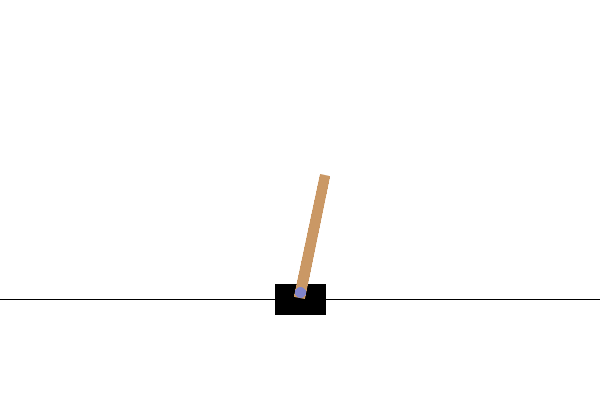

In [17]:
from PIL import Image
from IPython.display import display, clear_output
import gymnasium as gym
import time

env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()

for t in range(500):
    frame = env.render()
    img = Image.fromarray(frame)
    clear_output(wait=True)
    display(img)
    time.sleep(0.03)

    action = env.action_space.sample()
    state, reward, done, truncated, _ = env.step(action)

    if done or truncated:
        break

env.close()


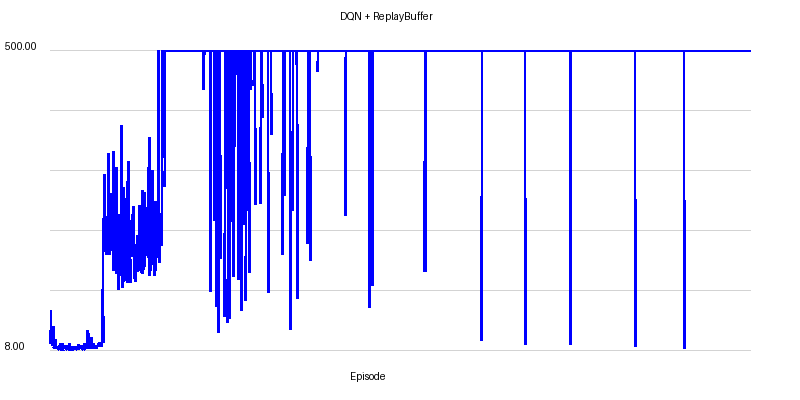

In [15]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Данные
window_size = 1
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')

width, height = 800, 400
padding = 50

data = moving_avg
if len(data) < 2:
    data = np.array([0, 0.1])

data_min, data_max = np.min(data), np.max(data)
normalized = (data - data_min) / (data_max - data_min + 1e-8)

img = Image.new('RGB', (width, height), color='white')
draw = ImageDraw.Draw(img)

x_scale = (width - 2 * padding) / (len(data) - 1)
y_scale = (height - 2 * padding)

points = [
    (padding + i * x_scale, height - padding - y * y_scale)
    for i, y in enumerate(normalized)
]

# Сетка
n_lines = 5
for i in range(n_lines + 1):
    y = padding + i * (height - 2 * padding) / n_lines
    draw.line([(padding, y), (width - padding, y)], fill='lightgray')

# Подписи осей
font = ImageFont.load_default()
draw.text((width // 2 - 50, height - 30), "Episode", fill='black', font=font)
draw.text((5, padding - 10), f"{data_max:.2f}", fill='black', font=font)
draw.text((5, height - padding - 10), f"{data_min:.2f}", fill='black', font=font)
draw.text((width // 2 - 60, 10), "DQN + ReplayBuffer", fill='black', font=font)

# Линия графика
draw.line(points, fill='blue', width=2)

display(img)
